# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [7]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd
import os
from torch.optim import lr_scheduler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [2]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [3]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [41]:
def train_test_model(epoch : int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     device: torch.device = 'cpu'):
    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []
    for epochs in range(epoch):
        epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
        train_loss_arr.append(epoch_loss / len(train_loader))

        scheduler.step(epoch_loss)
        after_lr = optimizer.param_groups[0]['lr']

        test_loss = test_step(model, test_loader, loss_fn, device)
        test_loss_arr.append(test_loss / len(test_loader))

        if (epochs) % 100 == 0 or epochs == 0:
            print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
        elif epochs + 1 == epoch:
            print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
    
    return train_loss_arr, test_loss_arr

Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

In [5]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               device: torch.device = 'cpu'):
    loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
        loss /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item()
            }

Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [6]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

***

## Εισαγωγή δεδομένων

Η συνάρτηση αυτή δέχεται τα paths των δεδομένων, δημιουργεί και επιστρέφει τα mini_batches που θα χρησιμοποιηθούν στο training.

In [ ]:
def data_func(input_array, labels, batch_size = 32, test_size = 0.2):
    # Reshape the tensor to 2D so that it can be used in the linear model
    X = input_array.reshape(len(input_array), -1)
    y = labels[:,:2]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler = StandardScaler()
    # Fit the scaler on the training data and transform both the training and test sets
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Transform the data to PyTorch tensors and move them to the GPU if available
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the dataset
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Define the data loader
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [34]:
# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

parent_dir = os.path.join(parent_dir, '..', 'Experiments', 'Raw_Data_0') # FTIAKSTO NA DIABAZEI SOSTA TA DATA RE MOGGOLE TI EINAI AYTO


rfid_label = np.load(f"{parent_dir}\\final_labels.npy")
info_tensor = np.load(f"{parent_dir}\\final_tensor.npy")

rfid_label = rfid_label[:,:2]

info_tensor.shape , rfid_label.shape

((1013, 500, 4), (1013, 2))

Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως **κινήθηκε** και την μέτρηση της **φάσης** του.

In [35]:
train_loader, test_loader = data_func(info_tensor, rfid_label)

(1013, 2000) (1013, 2)


In [36]:
len(train_loader) # Should be (total_tags / batch_size) * train_partition rounded to the upper integer

26

Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [37]:
output_len = rfid_label.shape[1]
input_len = info_tensor.shape[1] * info_tensor.shape[2]

input_len,output_len

(2000, 2)

***

## Αρχιτεκτονικές

### Αρχιτεκτονική 1

Το πρώτο μας μοντέλο θα είναι η απλούστερη περίπτωση ενός γραμμικού layer με είσοδο το ```input_size``` δηλαδή 4000 (για την ώρα) , και έξοδο 2 (x,y), χωρίς για αρχή κάποια συνάρτηση ενεργοποίησης.

Σαν συνάρτηση λάθους θα χρησιμοποιηθεί η ```MSELoss``` ενώ σαν optimizers θα δοκιμαστούν οι ```Adam```, ```RMSProp```, ```SGD```.

In [38]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= output_size),  
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 12985.259127103365 | Loss test: 12705.479910714286 | lr = 0.01
Epoch 100 | Loss train: 8203.613713191105 | Loss test: 7947.924386160715 | lr = 0.01
Epoch 200 | Loss train: 4729.86679311899 | Loss test: 4587.049386160715 | lr = 0.01
Epoch 300 | Loss train: 2422.2474834735576 | Loss test: 2345.3255440848216 | lr = 0.01
Epoch 400 | Loss train: 1121.5800123948318 | Loss test: 1020.7491280691964 | lr = 0.01
Epoch 500 | Loss train: 395.82115349402795 | Loss test: 399.83474513462613 | lr = 0.01
Epoch 600 | Loss train: 190.13856212909405 | Loss test: 255.09901428222656 | lr = 0.01
Epoch 700 | Loss train: 167.18041816124548 | Loss test: 219.24020494733537 | lr = 1.0000000000000002e-07
Epoch 800 | Loss train: 167.3754516014686 | Loss test: 219.23931121826172 | lr = 1.0000000000000004e-08
Epoch 900 | Loss train: 168.19837379455566 | Loss test: 219.23880985804968 | lr = 1.0000000000000004e-08
Epoch 1000 | Loss train: 167.88287294827975 | Loss test: 219.23827907017298 | lr = 1

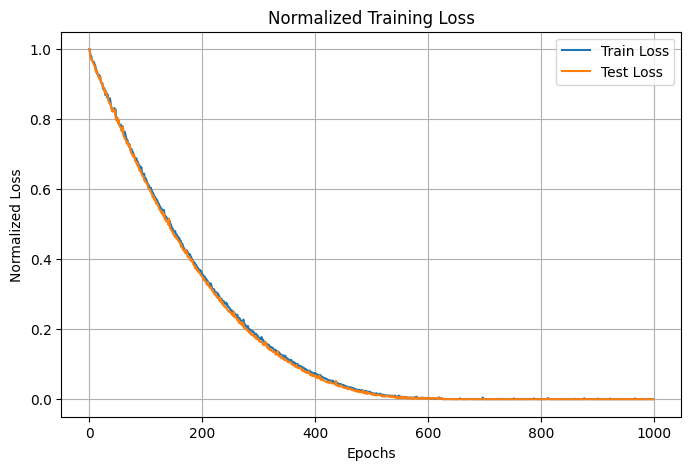

In [42]:
# Instantiate the model
model_0 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 1000,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Χρησιμοποιήσαμε τον optimizer ``` Adam ``` τώρα θα χρησιμοποιήσουμε τον ``` RMSProp```

Epoch 0 | Loss train: 13759.972881610576 | Loss test: 12942.86607142857 | lr = 0.01
Epoch 100 | Loss train: 8058.323523888221 | Loss test: 7961.693429129465 | lr = 0.01
Epoch 200 | Loss train: 4637.603844275842 | Loss test: 4427.896379743303 | lr = 0.01
Epoch 300 | Loss train: 2379.137413611779 | Loss test: 2221.4032679966517 | lr = 0.01
Epoch 400 | Loss train: 1045.125957782452 | Loss test: 1044.237060546875 | lr = 0.01
Epoch 500 | Loss train: 355.3403525719276 | Loss test: 399.67636326381137 | lr = 0.01
Epoch 600 | Loss train: 171.58892470139725 | Loss test: 217.37362016950334 | lr = 1e-05
Epoch 700 | Loss train: 168.75881913992075 | Loss test: 217.32814243861608 | lr = 1.0000000000000004e-08
Epoch 800 | Loss train: 169.21061559823843 | Loss test: 217.32650756835938 | lr = 1.0000000000000004e-08
Epoch 900 | Loss train: 169.82902204073392 | Loss test: 217.32558223179407 | lr = 1.0000000000000004e-08
Epoch 1000 | Loss train: 169.48019262460562 | Loss test: 217.32427324567522 | lr = 1.0

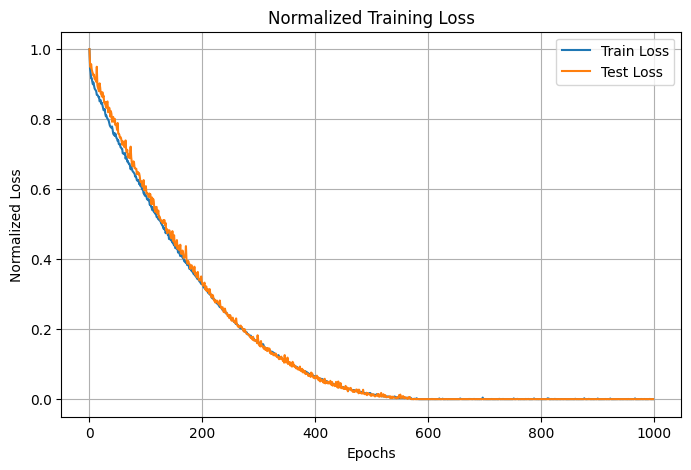

In [43]:
# Instantiate the model
model_1 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model_1.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 1000,model = model_1, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Και τέλος χρησιμοποιούμε και τον ``` SGD ```

Epoch 0 | Loss train: 13021.972806490385 | Loss test: 12746.080636160714 | lr = 0.01
Epoch 100 | Loss train: 7636.139028695913 | Loss test: 7466.021065848215 | lr = 0.01
Epoch 200 | Loss train: 3847.4026724008413 | Loss test: 3760.134695870536 | lr = 0.01
Epoch 300 | Loss train: 1460.5629225510818 | Loss test: 1421.4305943080358 | lr = 0.01
Epoch 400 | Loss train: 413.5186755840595 | Loss test: 405.197745186942 | lr = 0.01
Epoch 500 | Loss train: 198.2097913301908 | Loss test: 218.08863067626953 | lr = 0.01
Epoch 600 | Loss train: 182.37673832820013 | Loss test: 213.24489811488561 | lr = 1.0000000000000002e-07
Epoch 700 | Loss train: 179.15995436448318 | Loss test: 213.24500819614954 | lr = 1.0000000000000004e-08
Epoch 800 | Loss train: 180.06900493915265 | Loss test: 213.24504961286272 | lr = 1.0000000000000004e-08
Epoch 900 | Loss train: 181.11666341928336 | Loss test: 213.2451226370675 | lr = 1.0000000000000004e-08
Epoch 1000 | Loss train: 179.83813212468073 | Loss test: 213.2451913

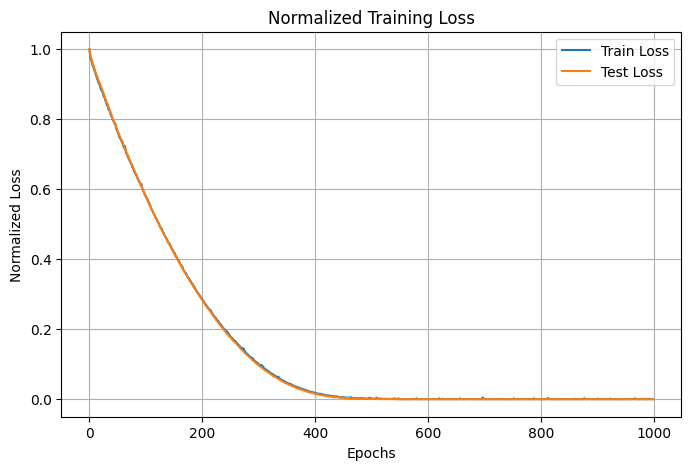

In [44]:
# Instantiate the model
model_2 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=learning_rate, momentum= 0.9)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 1000,model = model_2, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Έχοντας προπονήσει τα μοντέλα για 100 εποχές με διαφορετικούς optimizers παρατηρούμε ότι η καλύτερη απόδοση έιναι από τον ``` Adam ``` ο οποίος θα χρησιμοποιηθεί και μετέπειτα.

***

### Αρχιτεκτονική 2

#### ReLU 128

Το δεύτερο μοντέλο μας θα αποκτήσει άλλα 2 layers δίνοντας μας την δυνατότητα θεωρητικά να πετύχουμε μικρότερη απώλεια συγκριτικά με την απλούστερη περίπτωση. Επιπλέον μας δίνεται η δυνατότητα να μεταβάλλουμε τόσο την μεταβλητή ```hidden_units``` που καθορίζει το μέγεθος των ενδιάμεσων επιπέδων, όσο και τις συναρτήσεις ενεργοποίησης.

Για αρχή επιλέγουμε την συνηθέστερη επιλογή την συνάρτηση ``` ReLU```, ο τύπος της οποίας δίνεται παρακάτω.

$ReLU(x) = max(0,x)$

In [45]:
# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 5592.455669696515 | Loss test: 1703.7205461774554 | lr = 0.01
Epoch 100 | Loss train: 102.47141808729906 | Loss test: 493.45787266322543 | lr = 0.001
Epoch 200 | Loss train: 48.412039023179275 | Loss test: 545.8175789969308 | lr = 0.001
Epoch 300 | Loss train: 23.64636523907001 | Loss test: 592.6778782435825 | lr = 0.0001
Epoch 400 | Loss train: 21.468169102301964 | Loss test: 593.3261195591518 | lr = 1.0000000000000004e-08
Epoch 500 | Loss train: 21.484060214116024 | Loss test: 593.319580078125 | lr = 1.0000000000000004e-08
Epoch 600 | Loss train: 22.088323996617245 | Loss test: 593.3136422293527 | lr = 1.0000000000000004e-08
Epoch 700 | Loss train: 21.849581443346462 | Loss test: 593.3048836844308 | lr = 1.0000000000000004e-08
Epoch 800 | Loss train: 21.444730905386116 | Loss test: 593.2957284109933 | lr = 1.0000000000000004e-08
Epoch 900 | Loss train: 21.459189268258903 | Loss test: 593.2882559640067 | lr = 1.0000000000000004e-08
Epoch 1000 | Loss train: 21.393

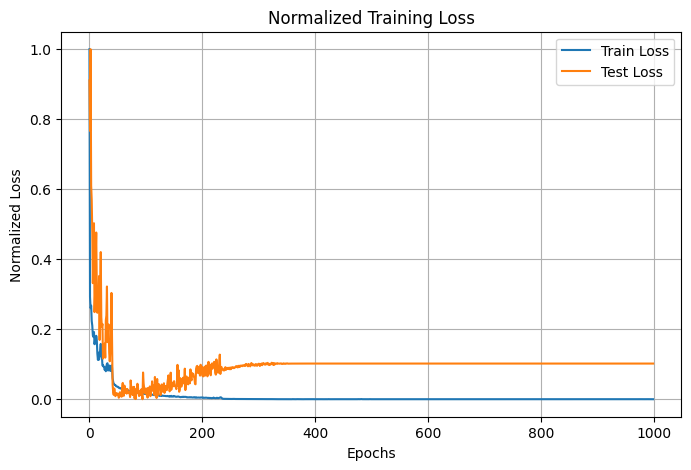

In [47]:
# Instantiate the model
model_3 = ReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 1000,model = model_3, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model = eval_model(model_3, test_loader, loss_fn, device)

In [48]:
relu_model

{'model_name': 'ReLUModel', 'model_loss': 593.2779541015625}

Ήδη τα αποτελέσματα είναι πολύ καλύτερα συγκριτικά με την προηγούμενη αρχιτεκτονική. **NOT**

#### ReLU 256

Τώρα θα αυξήσουμε τον αριθμό των ```hidden_units```  από 128 σε 256 για να δούμε κάποια πιθανή διαφορά.

Epoch 0 | Loss train: 4264.435776930589 | Loss test: 1531.4067905970983 | lr = 0.01
Epoch 100 | Loss train: 161.03157923771784 | Loss test: 458.27922494070873 | lr = 0.001
Epoch 200 | Loss train: 51.72408045255221 | Loss test: 479.16086033412387 | lr = 0.0001
Epoch 300 | Loss train: 47.25491743821364 | Loss test: 480.4650671822684 | lr = 1.0000000000000004e-08
Epoch 400 | Loss train: 47.12857532501221 | Loss test: 480.4593756539481 | lr = 1.0000000000000004e-08
Epoch 500 | Loss train: 47.98881325354943 | Loss test: 480.45791407993863 | lr = 1.0000000000000004e-08


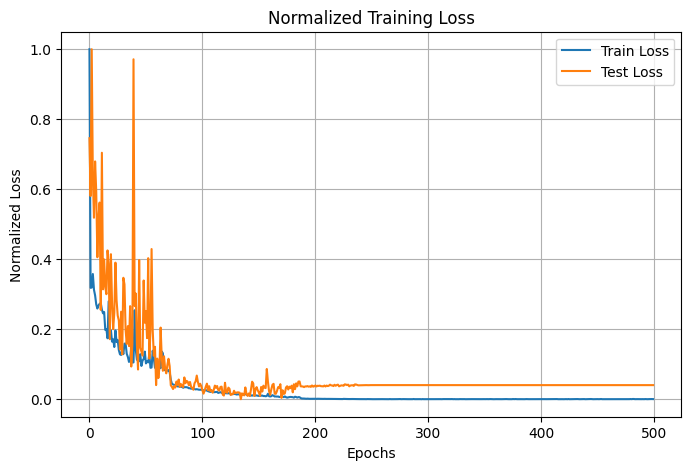

In [50]:
# Instantiate the model
model_4 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 256)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 500,model = model_4, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model_256 = eval_model(model_4, test_loader, loss_fn, device)

In [51]:
relu_model_256, relu_model

({'model_name': 'ReLUModel', 'model_loss': 480.4579162597656},
 {'model_name': 'ReLUModel', 'model_loss': 593.2779541015625})

#### ReLU 64

Τα αποτελέσματα με 128 hidden units είναι καλύτερα, δοκιμάζουμε τέλος με 64. **NOT**

Epoch 0 | Loss train: 4381.966810960036 | Loss test: 2000.942661830357 | lr = 0.01
Epoch 100 | Loss train: 100.72412916330191 | Loss test: 353.7944074358259 | lr = 0.001
Epoch 200 | Loss train: 49.14862999549279 | Loss test: 364.5743495396205 | lr = 0.001
Epoch 300 | Loss train: 25.707677657787617 | Loss test: 371.57942853655135 | lr = 0.0001
Epoch 400 | Loss train: 22.474676572359524 | Loss test: 379.0198669433594 | lr = 1.0000000000000002e-06
Epoch 500 | Loss train: 22.870302530435417 | Loss test: 379.06056431361606 | lr = 1.0000000000000004e-08


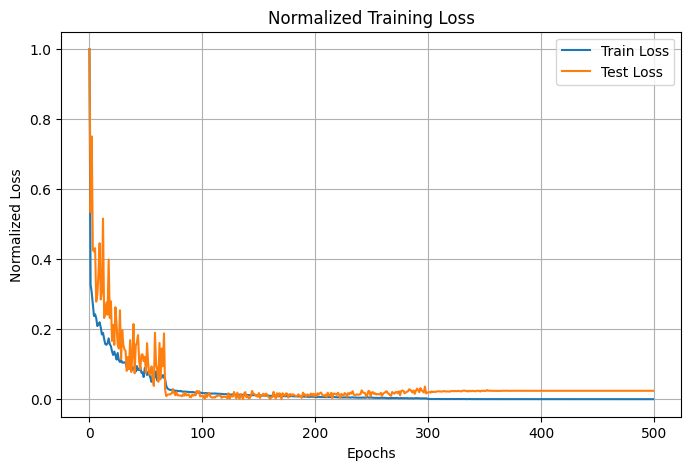

In [53]:
# Instantiate the model
model_5 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 64)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 500,model = model_5, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model_64 = eval_model(model_5, test_loader, loss_fn, device)

In [54]:
relu_model_256, relu_model_64, relu_model

({'model_name': 'ReLUModel', 'model_loss': 480.4579162597656},
 {'model_name': 'ReLUModel', 'model_loss': 379.0605773925781},
 {'model_name': 'ReLUModel', 'model_loss': 593.2779541015625})

Η καλύτερη περίπτωση φαίνεται να είναι με 64 ```hidden_units```

***

### Αρχιτεκτονική 2.1

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [55]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 4905.318857046274 | Loss test: 2407.62109375 | lr = 0.01
Epoch 100 | Loss train: 210.2888928926908 | Loss test: 397.19927978515625 | lr = 0.01
Epoch 200 | Loss train: 37.486155656667854 | Loss test: 324.31046404157365 | lr = 0.001
Epoch 300 | Loss train: 12.265566569108229 | Loss test: 323.3443603515625 | lr = 0.001
Epoch 400 | Loss train: 5.698468079933753 | Loss test: 326.35362461635043 | lr = 0.0001
Epoch 500 | Loss train: 4.839594263296861 | Loss test: 329.46612548828125 | lr = 0.0001


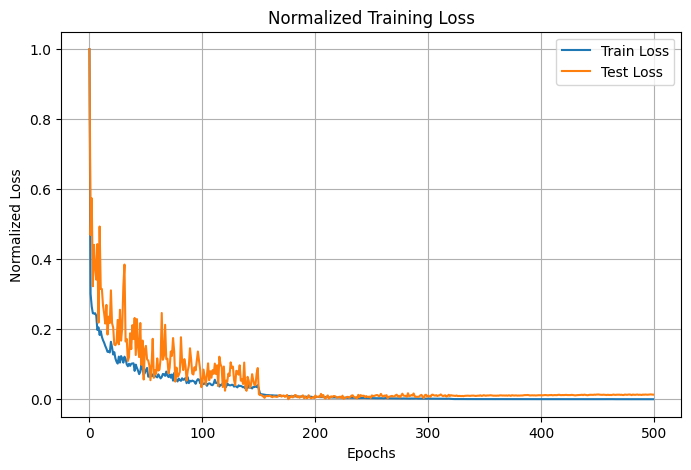

In [56]:
# Instantiate the model
model_6 = LeakyReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 500,model = model_6, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu = eval_model(model_6, test_loader, loss_fn, device)

#### Tanh

Δοκιμάζουμε την συνάρτηση ενεργοποίησης tanh. 

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

In [58]:
class tanhModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(tanhModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 12807.967172475961 | Loss test: 12117.591378348214 | lr = 0.01
Epoch 100 | Loss train: 105.94805908203125 | Loss test: 214.02627999441964 | lr = 0.001
Epoch 200 | Loss train: 68.31970977783203 | Loss test: 225.28382655552454 | lr = 0.001
Epoch 300 | Loss train: 61.637426082904526 | Loss test: 221.310302734375 | lr = 1.0000000000000004e-08
Epoch 400 | Loss train: 63.41887488731971 | Loss test: 221.31034415108817 | lr = 1.0000000000000004e-08
Epoch 500 | Loss train: 61.89726946904109 | Loss test: 221.31060791015625 | lr = 1.0000000000000004e-08


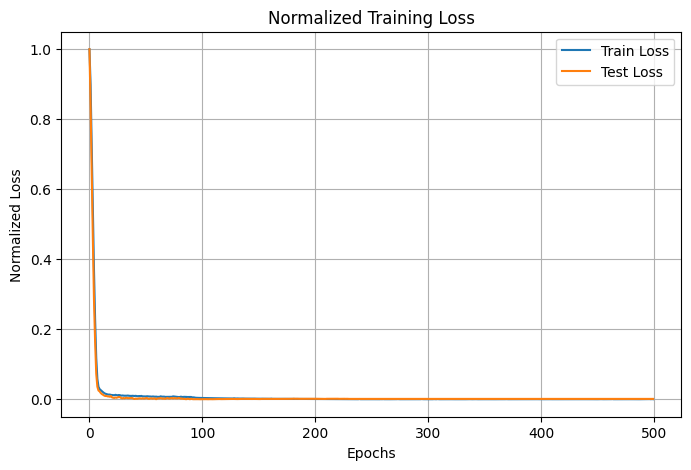

In [59]:
# Instantiate the model
model_8 = tanhModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_8.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 500,model = model_8, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

tanh_model = eval_model(model_8, test_loader, loss_fn, device)

#### Sigmoid

$Sigmoid(x) = \frac{1}{1+exp(-x)}$

In [60]:
class sigmoidModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(sigmoidModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 11886.901029146635 | Loss test: 10384.474609375 | lr = 0.01
Epoch 100 | Loss train: 103.62201133141151 | Loss test: 210.13729204450334 | lr = 0.001
Epoch 200 | Loss train: 83.84822874802809 | Loss test: 207.74176679338728 | lr = 0.001
Epoch 300 | Loss train: 74.51753366910495 | Loss test: 208.1799098423549 | lr = 1.0000000000000002e-06
Epoch 400 | Loss train: 72.94260318462665 | Loss test: 208.17788696289062 | lr = 1.0000000000000004e-08
Epoch 500 | Loss train: 73.54591149550218 | Loss test: 208.17765590122767 | lr = 1.0000000000000004e-08


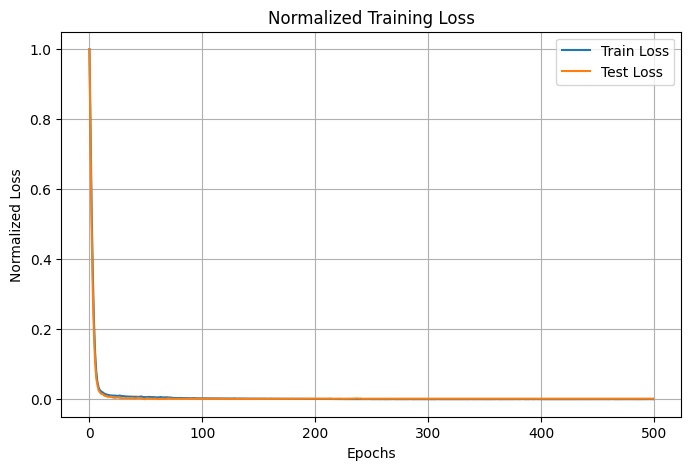

In [62]:
# Instantiate the model
model_9 = sigmoidModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_9.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 500,model = model_9, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

sigmoid_model = eval_model(model_9, test_loader, loss_fn, device)

### Αρχιτεκτονική 3

#### +1 Layer

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [63]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 10815.665175217848 | Loss test: 2006.8213065011162 | lr = 0.01
Epoch 100 | Loss train: 107.83598327636719 | Loss test: 341.39932904924666 | lr = 0.001
Epoch 200 | Loss train: 25.95530157822829 | Loss test: 409.31183951241627 | lr = 0.001
Epoch 300 | Loss train: 12.560444868527926 | Loss test: 430.8262481689453 | lr = 0.001
Epoch 400 | Loss train: 3.4473652885510373 | Loss test: 432.93963623046875 | lr = 0.0001
Epoch 500 | Loss train: 2.4481049340504866 | Loss test: 446.46207101004467 | lr = 0.0001


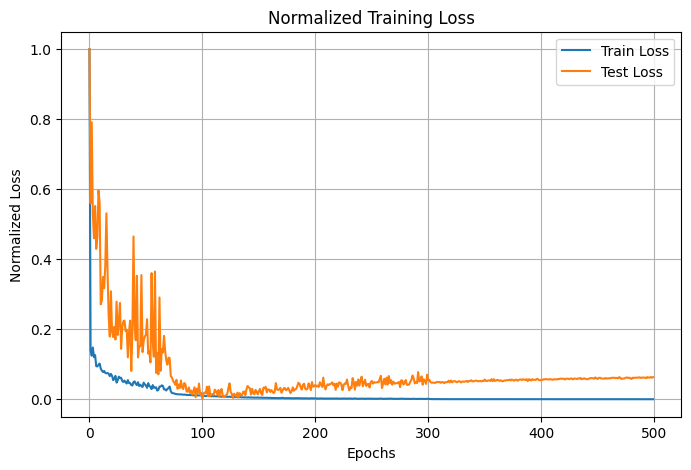

In [65]:
# Instantiate the model
model_10 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_10.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 500,model = model_10, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu_4 = eval_model(model_10, test_loader, loss_fn, device)

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

#### -1 Layer

In [70]:
class LeakyReLUModel2(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 4401.537301870493 | Loss test: 1564.6512102399554 | lr = 0.01
Epoch 100 | Loss train: 298.41051424466644 | Loss test: 438.98616681780135 | lr = 0.01
Epoch 200 | Loss train: 78.85456569378192 | Loss test: 236.35096958705358 | lr = 0.001
Epoch 300 | Loss train: 55.63954720130334 | Loss test: 198.86607578822546 | lr = 0.001
Epoch 400 | Loss train: 43.172890369708725 | Loss test: 194.5533719744001 | lr = 1.0000000000000004e-08
Epoch 500 | Loss train: 43.50945414029635 | Loss test: 194.55352129255022 | lr = 1.0000000000000004e-08


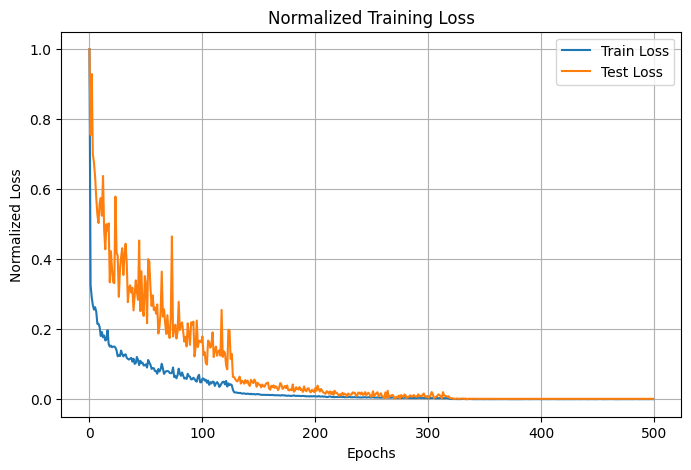

In [71]:
# Instantiate the model
model_14 = LeakyReLUModel2(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_14.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 500,model = model_14, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu_2 = eval_model(model_14, test_loader, loss_fn, device)

### Αρχιτεκτονική 4

#### Dropout

Θα προσθέσουμε ένα άλλο επίπεδο που συνίσταται σε μοντέλα με μικρά datasets, το ```Dropout```. Αυτό, με πιθανότητα p "νεκρώνει" έναν νευρώνα, βοηθώντας έτσι το μοντέλο να κατανοήσει γενικότερα συμπεράσματα για τα δεδομένα που του δίνουμε.

In [72]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 6606.476182204026 | Loss test: 2584.12948172433 | lr = 0.01
Epoch 100 | Loss train: 424.6489645150992 | Loss test: 395.07004002162387 | lr = 0.001
Epoch 200 | Loss train: 378.31440500112683 | Loss test: 352.1265127999442 | lr = 1.0000000000000004e-08
Epoch 300 | Loss train: 335.08758134108325 | Loss test: 352.13199506487166 | lr = 1.0000000000000004e-08
Epoch 400 | Loss train: 325.97310403677136 | Loss test: 352.13648550851 | lr = 1.0000000000000004e-08
Epoch 500 | Loss train: 350.9804928119366 | Loss test: 352.13978358677457 | lr = 1.0000000000000004e-08


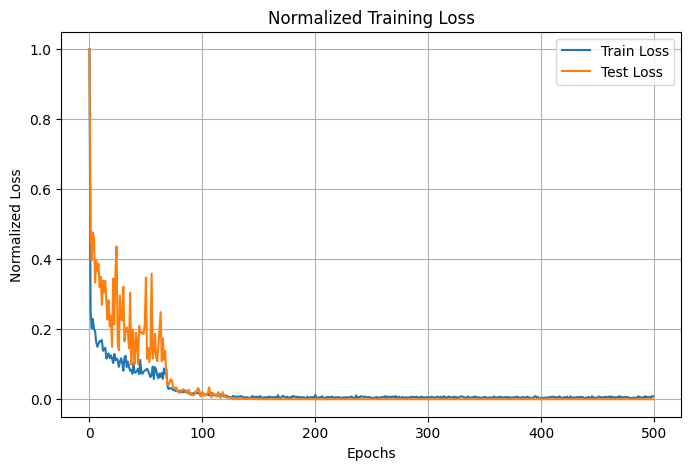

In [74]:
# Instantiate the model
model_11 = LeakyReLUModelDropout(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_11.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 500,model = model_11, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

dropout_model = eval_model(model_11, test_loader, loss_fn, device)

### Αρχιτεκτονική 5

#### XGB

Θα χρησιμοποιήσουμε και τον γνωστό αλγόριθμο για regression XGB, με την βοήθεια του MultiOutputRegressor.

In [75]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [76]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.01, eta = 0.2, tree_method = 'hist', device = 'cuda')

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

xgb_loss = mean_squared_error(y_test, y_pred)

xgb_res = {'model_name': 'xgb_model', 'model_loss' : xgb_loss}

c:\Users\jimka\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:25:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### Αρχιτεκτονική 6

#### Epochs

Θα δοκιμάσουμε επίσης αντί να δημιουργούμε batches να περνάμε τα data απευθείας στο μοντέλο.

Για την δοκιμή αυτή θα χρησιμοποιήσουμε το μοντέλο LeakyReLUModel4 με συνάρτηση ενεργοποίησης την LeakyReLU και 4 επίπεδα.

Δεν δημιουργώ συναρτήσεις αφού είναι μεμονομένη περίπτωση.

In [77]:
# Instantiate the model
model_13 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_13.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [78]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [79]:
# Set seed before defining model and optimizer
torch.manual_seed(42)  

# Move model to device **before** training
model_13.to(device)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

# Set number of epochs
epochs = 1000  

# Training loop
for epoch in range(epochs):
    model_13.train()
    
    # Forward pass
    y_pred = model_13(X_train_tensor)

    # Compute loss
    loss = loss_fn(y_pred, y_train_tensor)  

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model_13.eval()
    with torch.inference_mode():
        test_logits = model_13(X_test_tensor)
        test_loss = loss_fn(test_logits, y_test_tensor).detach()  # Ensure no gradients


    # Update learning rate scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(test_loss.detach())  
    else:
        scheduler.step()

    # Print every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

epoch_res = {'model_name': 'LeakyReLU4_noBatches', 'model_loss' : test_loss.cpu().item()}

Epoch: 0 | Train Loss: 13098.15234 | Test Loss: 12405.91113
Epoch: 100 | Train Loss: 442.19534 | Test Loss: 606.50201
Epoch: 200 | Train Loss: 264.81638 | Test Loss: 545.04956
Epoch: 300 | Train Loss: 264.81543 | Test Loss: 545.04694
Epoch: 400 | Train Loss: 264.81427 | Test Loss: 545.04346
Epoch: 500 | Train Loss: 264.81284 | Test Loss: 545.03900
Epoch: 600 | Train Loss: 264.81113 | Test Loss: 545.03363
Epoch: 700 | Train Loss: 264.80920 | Test Loss: 545.02747
Epoch: 800 | Train Loss: 264.80701 | Test Loss: 545.02045
Epoch: 900 | Train Loss: 264.80469 | Test Loss: 545.01239
Epoch: 1000 | Train Loss: 264.80219 | Test Loss: 545.00348


## Results

In [80]:
compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, leakyrelu_2, relu_model,dropout_model, sigmoid_model, tanh_model])
compare_results = compare_results._append(xgb_res, ignore_index = True)
compare_results = compare_results._append(epoch_res, ignore_index = True)
compare_results.sort_values(by = 'model_loss', ascending= True, inplace= True)

compare_results['model_loss'] = compare_results['model_loss'].apply(np.sqrt)

compare_results

,model_name,model_loss
7,xgb_model,12.576378
2,LeakyReLUModel2,13.948245
5,sigmoidModel,14.428364
6,tanhModel,14.876512
0,LeakyReLUModel,18.151202
4,LeakyReLUModelDropout,18.765388
1,LeakyReLUModel4,21.129649
8,LeakyReLU4_noBatches,23.345310
3,ReLUModel,24.357298


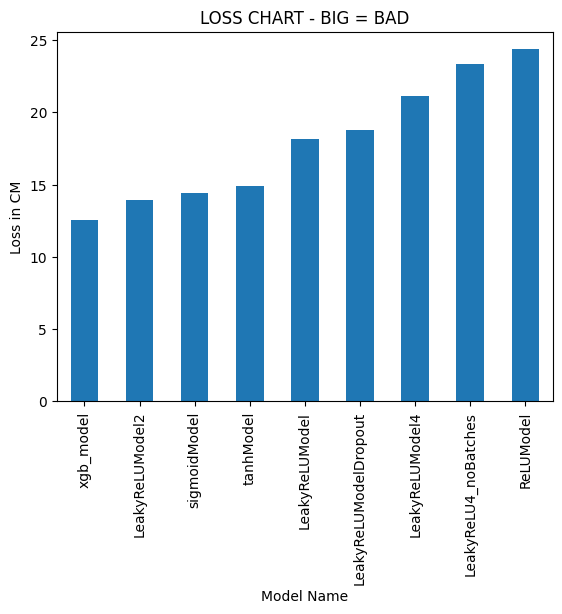

In [82]:
# Visualize our model results
compare_results.set_index("model_name")["model_loss"].plot(kind="bar")
plt.xlabel("Model Name")
plt.ylabel("Loss in CM")
plt.title("LOSS CHART - BIG = BAD")
plt.show()

***